In [1]:
import matplotlib.pyplot as plt
import mne
import numpy as np
from joblib import Memory
from toto.inference.embedding import embed
from umap import UMAP

from mushroom_hyperscanning.data import load_eeg
from mushroom_hyperscanning.utils import batched_sliding_window

memory = Memory("./cache")

In [2]:
CEREMONY = "ceremony2"
BIDS_ROOT = "../data/003_sanitization"

In [3]:
def preproc(raw: mne.io.Raw) -> mne.io.Raw:
    raw.drop_channels(["ECG", "CM", "A1", "A2", "Ax", "Ay", "Az"], on_missing="ignore")
    raw.set_montage("standard_1020")
    raw.filter(2, 50, n_jobs=-1)
    return raw


cur = preproc(load_eeg("01", CEREMONY, BIDS_ROOT, preload=True))
pat = preproc(load_eeg("04", CEREMONY, BIDS_ROOT, preload=True))

Extracting EDF parameters from c:\Users\pthoe\projects\mexico\mushroom_hyperscanning\data\003_sanitization\sub-01\ses-ceremony2\eeg\sub-01_ses-ceremony2_task-psilo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6098999  =      0.000 ... 20329.997 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 495 samples (1.650 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    2.3s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    2.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    2.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    3.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.3s finished


Extracting EDF parameters from c:\Users\pthoe\projects\mexico\mushroom_hyperscanning\data\003_sanitization\sub-04\ses-ceremony2\eeg\sub-04_ses-ceremony2_task-psilo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6098999  =      0.000 ... 20329.997 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 495 samples (1.650 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    1.5s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    1.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    2.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.4s finished


In [4]:
@memory.cache
def embed_raw(raw, window_size=1024, step_size=800, batch_size=256):
    embed_wrapper = lambda x, sfreq: embed(x, global_average=True).numpy()
    return batched_sliding_window(
        raw, embed_wrapper, window_size=window_size, step_size=step_size, batch_size=batch_size, n_jobs=1
    )


# embed curandero eeg
ct, cz = embed_raw(cur)
cz = np.array(cz)
# embed patient eeg
pt, pz = embed_raw(pat)
pz = np.array(pz)

In [5]:
def scatter_components(t1, c1, t2, c2, label1="curandero", label2="patient", title=""):
    plt.figure(figsize=(16, 5))
    plt.suptitle(title)
    plt.subplot(121)
    plt.scatter(*c1.T, c=plt.get_cmap("spring")(t1 / t1.max()), alpha=0.05, label=label1)
    plt.scatter(*c2.T, c=plt.get_cmap("winter")(t2 / t2.max()), alpha=0.05, label=label2)
    legend = plt.legend()
    for handle in legend.legend_handles:
        handle.set_alpha(1)

    plt.subplot(122)
    plt.scatter(*c1.T, alpha=0.1, label=label1)
    plt.scatter(*c2.T, alpha=0.1, label=label2)
    legend = plt.legend()
    for handle in legend.legend_handles:
        handle.set_alpha(1)
    plt.show()

In [6]:
est = UMAP().fit(np.concatenate([cz, pz], axis=0))
ccomps = est.transform(cz)
pcomps = est.transform(pz)

c:\Users\pthoe\miniforge3\envs\env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\pthoe\miniforge3\envs\env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\pthoe\miniforge3\envs\env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


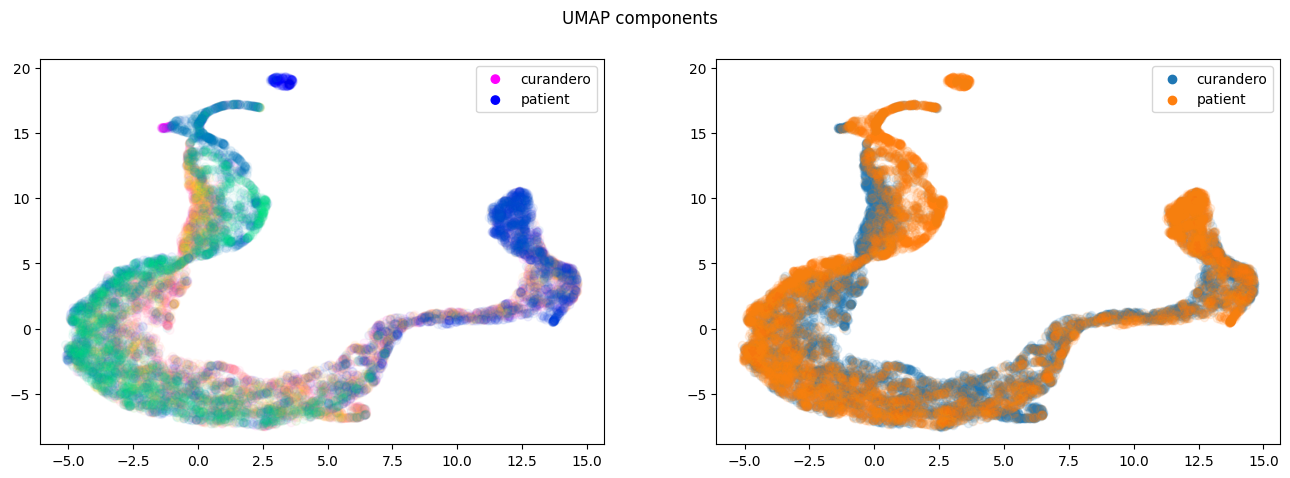

In [7]:
scatter_components(ct, ccomps, pt, pcomps, label1="curandero", label2="patient", title="UMAP components")

In [8]:
from deeptime.decomposition import VAMP

est = VAMP(lagtime=5, dim=2).fit(np.concatenate([cz, pz], axis=0))
ccomps = est.transform(cz)
pcomps = est.transform(pz)

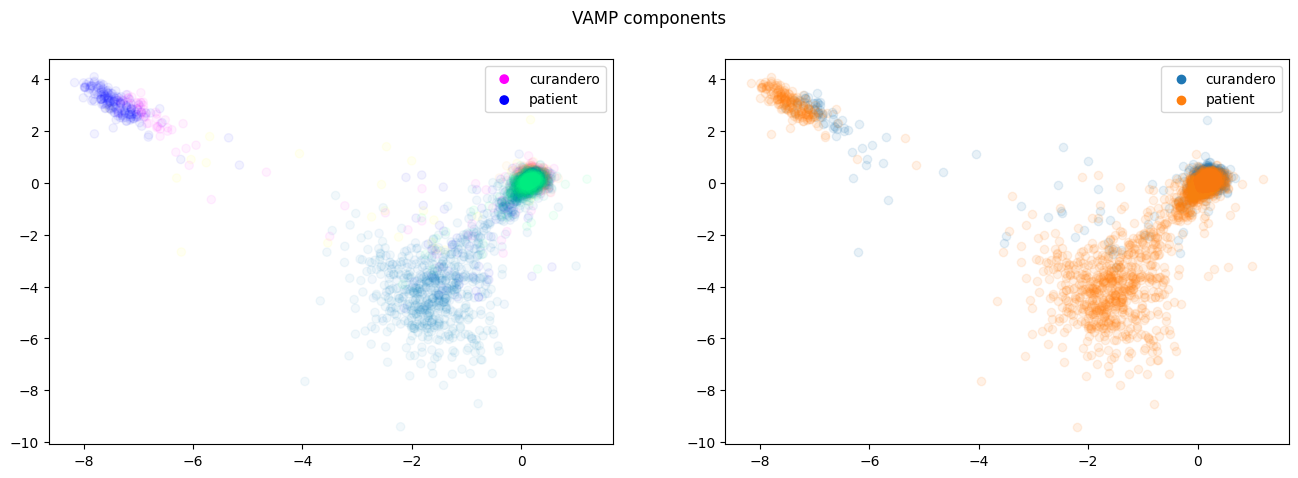

In [9]:
scatter_components(ct, ccomps, pt, pcomps, label1="curandero", label2="patient", title="VAMP components")